In [19]:
import os
import glob
import math

from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits, ascii

import spectroscopy as spec

from astropy.modeling import models, fitting

In [4]:
EFOSC_DIR = '../data/spectra/EFOSC/'
XSHOOTER_DIR = '../data/spectra/xshooter/'
FIG_DIR = '../figures/'
NaD2 = 5890
NaD1 = 5896
redshift_15oz = 0.006929

# Look at EFOSC to see if it has high enough resolution

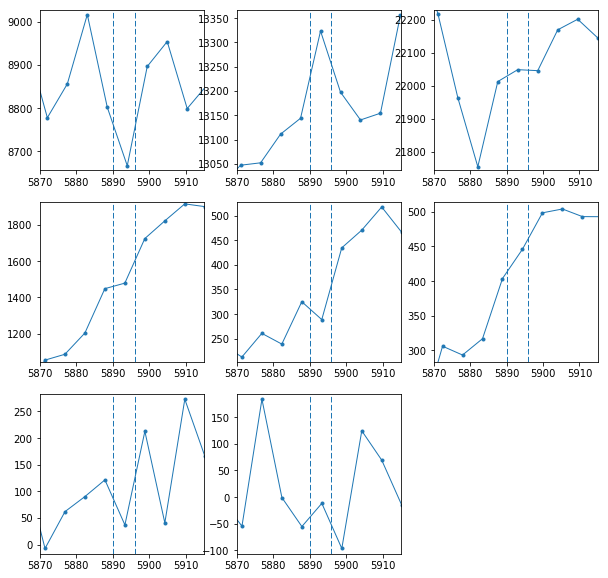

In [36]:
flist = glob.glob(os.path.join(EFOSC_DIR, '*ex.fits'))
fig = plt.figure(figsize=[10,10])
n_ax = len(flist)
n_side = math.ceil(math.sqrt(n_ax))

for i, ifile in enumerate(flist):
    ofile = fits.open(ifile)
    optimal_extra = ofile[0].data[0,0,:]
    wl = spec.calc_wavelength(ofile[0].header, np.arange(len(optimal_extra)))
    deredshift_wl = spec.apply_redshift(wl, redshift_15oz)
    ax = fig.add_subplot(n_side, n_size, i+1)
    plt.plot(deredshift_wl, optimal_extra, 'o-')
    plt.axvline(NaD2, linestyle='--')
    plt.axvline(NaD1, linestyle='--')
    plt.xlim(5870, 5915)
    
    lims = optimal_extra[(deredshift_wl > 5870)&(deredshift_wl<5915)]
    plt.ylim(np.min(lims)-10, np.max(lims)+10)
    

It doesnt

# Look at XSHOOTER Data

In [5]:
tbdata = ascii.read(os.path.join(XSHOOTER_DIR, 'ASASSN15oz_VLT_20150921.txt'), 
                    names=['wavelength', 'flux', 'flux_err'])

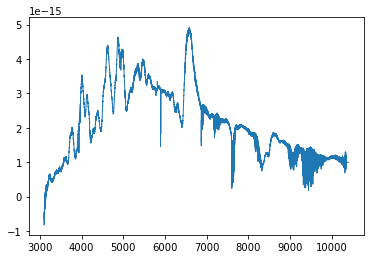

In [110]:
plt.plot(tbdata['wavelength'], tbdata['flux'])
#plt.xlim(5885, 5900)
#plt.ylim(1E-15, 3.5E-15)

In [15]:
gauss = models.GaussianAbsorption1D?

In [38]:
na_model = models.GaussianAbsorption1D(mean=5890)+ \
           models.GaussianAbsorption1D(mean=5896)+ \
           models.Const1D()
#na_model = models.Lorentz1D(x_0=5890)+ \
#           models.Lorentz1D(x_0=5896)+ \
#           models.Const1D()
#na_model = models.Moffat1D(x_0=5890)+ \
#           models.Moffat1D(x_0=5896)+ \
#           models.Const1D()        
        
fitter = fitting.LevMarLSQFitter()

indx = (tbdata['wavelength']<=5900) & (tbdata['wavelength']>= 5887)

na_fit = fitter(na_model, tbdata['wavelength'][indx], tbdata['flux'][indx]/3E-15)


<CompoundModel31(amplitude_0=0.5524495939403918, mean_0=5890.5490358984935, stddev_0=0.3535092806329105, amplitude_1=0.42956787051844175, mean_1=5896.502591255544, stddev_1=0.32844053077732466, amplitude_2=-0.963678331122013)>

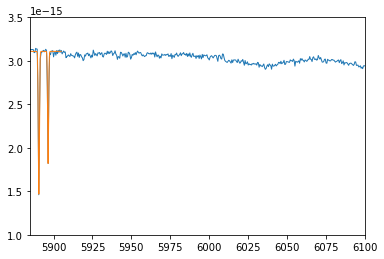

In [112]:
plt.plot(tbdata['wavelength'], tbdata['flux'])
plt.xlim(5885, 6100)
plt.ylim(1E-15, 3.5E-15)
x = np.arange(5885, 5905, 0.1)
plt.plot(x, na_fit(x)*3E-15)
na_fit

In [62]:
na_d2 = models.GaussianAbsorption1D(mean=5890, bounds={'mean':[5889, 5891]})+ \
        models.Const1D()
na_d1 = models.GaussianAbsorption1D(mean=5896, bounds={'mean':[5895, 5897]})+ \
        models.Const1D()
        
fitter = fitting.LevMarLSQFitter()

indx_d1 = (tbdata['wavelength']<=5900) & (tbdata['wavelength']>= 5893)
indx_d2 = (tbdata['wavelength']<=5893) & (tbdata['wavelength']>= 5887)
na_fit_d1 = fitter(na_d1, tbdata['wavelength'][indx_d1], tbdata['flux'][indx_d1]/3E-15)
na_fit_d2 = fitter(na_d2, tbdata['wavelength'][indx_d2], tbdata['flux'][indx_d2]/3E-15)

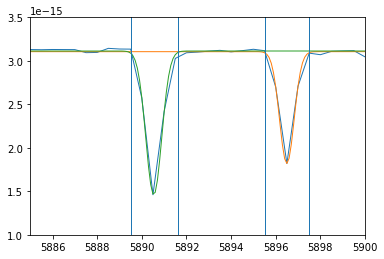

In [86]:
plt.plot(tbdata['wavelength'], tbdata['flux'])
plt.xlim(5885, 5900)
plt.ylim(1E-15, 3.5E-15)
x = np.arange(5885, 5905, 0.1)
plt.plot(x, na_fit_d1(x)*3E-15)
plt.plot(x, na_fit_d2(x)*3E-15)
plt.axvline(5889.5)
plt.axvline(5891.6)
plt.axvline(5895.5)
plt.axvline(5897.5)

In [114]:
d_lambda = 0.01
x_d2 = np.arange(5889.5, 5891.6, d_lambda)
model_flux_d2 = na_fit_d2(x_d2)
ew_d2 = np.sum((1-model_flux_d2/(1+na_fit_d2.amplitude_1))*d_lambda)
print('equivalent width for d2= {}'.format(ew_d2))
e_b_v_d2 = 10**(2.16*ew_d2-1.91)
print('E(B-V) for d1 using Poznanski 2012 = {}'.format(e_b_v_d2))

equivalent width for d2= 0.47279877990551844
E(B-V) for d1 using Poznanski 2012 = 0.12919489835743667


In [113]:
d_lambda = 0.01
x_d1 = np.arange(5895.5, 5897.5, d_lambda)
model_flux_d1 = na_fit_d1(x_d1)
ew_d1 = np.sum((1-model_flux_d1/(1+na_fit_d1.amplitude_1))*d_lambda)
print('equivalent width for d1= {}'.format(ew_d1))
e_b_v_d1 = 10**(2.47*ew_d1-1.76)
print('E(B-V) for d1 using Poznanski 2012 = {}'.format(e_b_v_d1))

equivalent width for d1= 0.3390142726835257
E(B-V) for d1 using Poznanski 2012 = 0.11949927034795603


# Check equivalent width calculation

In [97]:
norm_flux = tbdata['flux'][indx_d1]/np.median(tbdata['flux'][indx_d1])

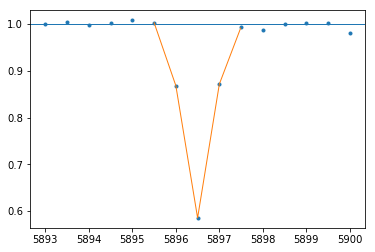

In [103]:
plt.plot(tbdata['wavelength'][indx_d1], norm_flux, 'o')
plt.axhline(1)
high_sample = np.interp(x_d1, tbdata['wavelength'][indx_d1], norm_flux)
plt.plot(x_d1,high_sample)

In [108]:
np.sum(d_lambda*(1-high_sample))

0.33857150989475993

## Values are correct. Close to Schlafly & Finkbierner 2011 - adopting that value